In [1]:
import pandas as pd
import numpy as np
#from torch.utils.tensorboard import SummaryWriter
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
import matplotlib.pyplot as plt
#from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, log_loss,
    jaccard_score, matthews_corrcoef, balanced_accuracy_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder

df_train = pd.read_csv("balanced_dataset.csv")
df_test = pd.read_csv("Fraud.csv")
df_test = df_test.drop(columns=['nameOrig','nameDest','isFlaggedFraud'])


scaler = StandardScaler()
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

# Validate transaction consistency: check if balance differences match the amount
def validate_transaction(row):
    source_diff = row['oldbalanceOrg'] - row['newbalanceOrig']
    dest_diff = row['newbalanceDest'] - row['oldbalanceDest']

    # Check if balance difference matches the amount
    if row['type'] in ['TRANSFER', 'CASH_OUT']:
        return (source_diff == row['amount']) and (dest_diff == -row['amount'])
    elif row['type'] in ['PAYMENT', 'DEBIT']:
        return source_diff == row['amount']
    elif row['type'] in ['CASH_IN', 'CASH_OUT']:
        return dest_diff == row['amount']
    else:
        return False

# Add validation column
df_train['isValidTransaction'] = df_train.apply(validate_transaction, axis=1)
df_test['isValidTransaction'] = df_test.apply(validate_transaction, axis=1)

# Encode transaction type
le = LabelEncoder()
df_test['type'] = le.fit_transform(df_test['type'])


# Split features and target
X_train = df_train.drop(['isFraud'], axis=1)
y_train = df_train['isFraud']
X_test = df_test.drop(['isFraud'], axis=1)
y_test = df_test['isFraud']

# Models for training and comparison
models = {
    #"Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    #"SVM": SVC(probability=True),
    "GaussianNB": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Extra Trees": ExtraTreesClassifier()
}
result = []
for model_name,model in models.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_prob = None

    #Now calculating the performance metrics of all the model
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        "Log Loss": log_loss(y_test, y_prob) if y_prob is not None else None,
        "Jaccard": jaccard_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred)
    }
    result.append(metrics)


result_df = pd.DataFrame(result)
result_df




,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss,Jaccard,MCC,Balanced Accuracy
0,KNN,0.986953,0.089609,0.994277,0.164402,0.999807,2.244734e-02,0.089563,0.296512,0.990611
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,2.220446e-16,1.000000,1.000000,1.000000
2,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,5.676477e-04,1.000000,1.000000,1.000000
3,GaussianNB,0.933042,0.011356,0.591136,0.022284,0.835673,3.745298e-01,0.011268,0.075238,0.762310
4,Gradient Boosting,0.983471,0.072159,0.995495,0.134564,0.998577,4.387071e-02,0.072136,0.265772,0.989475
5,AdaBoost,0.946344,0.022872,0.972361,0.044694,0.993094,4.765859e-01,0.022858,0.144836,0.959335
6,Extra Trees,1.000000,1.000000,1.000000,1.000000,1.000000,2.220446e-16,1.000000,1.000000,1.000000


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC

# Model
model = Sequential([
    Dense(160, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
)

# Summary
model.summary()


/Users/hardikpandey/Desktop/wd/V.2 ds/Accredian project/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
397151/397151 ━━━━━━━━━━━━━━━━━━━━ 592s 1ms/step - accuracy: 0.8366 - auc_1: 0.9136 - loss: 0.3613 - precision_1: 0.8635 - recall_1: 0.7988 - val_accuracy: 0.9938 - val_auc_1: 0.9904 - val_loss: 0.0352 - val_precision_1: 0.1258 - val_recall_1: 0.6386
Epoch 2/10
397151/397151 ━━━━━━━━━━━━━━━━━━━━ 491s 1ms/step - accuracy: 0.8852 - auc_1: 0.9566 - loss: 0.2651 - precision_1: 0.8984 - recall_1: 0.8686 - val_accuracy: 0.9969 - val_auc_1: 0.9673 - val_loss: 0.0242 - val_precision_1: 0.2212 - val_recall_1: 0.5606
Epoch 3/10
397151/397151 ━━━━━━━━━━━━━━━━━━━━ 570s 1ms/step - accuracy: 0.8866 - auc_1: 0.9575 - loss: 0.2625 - precision_1: 0.8993 - recall_1: 0.8707 - val_accuracy: 0.9900 - val_auc_1: 0.9816 - val_loss: 0.0498 - val_precision_1: 0.0813 - val_recall_1: 0.6548
Epoch 4/10
397151/397151 ━━━━━━━━━━━━━━━━━━━━ 536s 1ms/step - accuracy: 0.8927 - auc_1: 0.9617 - loss: 0.2498 - precision_1: 0.9031 - recall_1: 0.8798 - val_accuracy: 0.9670 - val_auc_1: 0.9851 - val_loss: 0.1339 -

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 160)            │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,925 (366.90 KB)

 Trainable params: 31,073 (121.38 KB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 62,148 (242.77 KB)

In [9]:
# Predicting probabilities
Y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels (threshold = 0.5)
Y_pred = (Y_pred_probs > 0.5).astype("int32").flatten()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Calculating metrics
accuracy = accuracy_score(y_test, Y_pred)
precision = precision_score(y_test, Y_pred)
recall = recall_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred)
auc = roc_auc_score(y_test, Y_pred_probs)  # use probabilities for AUC
cm = confusion_matrix(y_test, Y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print("Confusion Matrix:")
print(cm)


198832/198832 ━━━━━━━━━━━━━━━━━━━━ 67s 336us/step
Accuracy:  0.9970
Precision: 0.2364
Recall:    0.5860
F1 Score:  0.3369
AUC:       0.9494
Confusion Matrix:
[[6338864   15543]
 [   3400    4813]]


/var/folders/kq/zdst5kxx4x39_9w4n35yjf_w0000gn/T/ipykernel_7109/2578027401.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_df = pd.concat([filtered_df, pd.DataFrame([nn_metrics])], ignore_index=True)


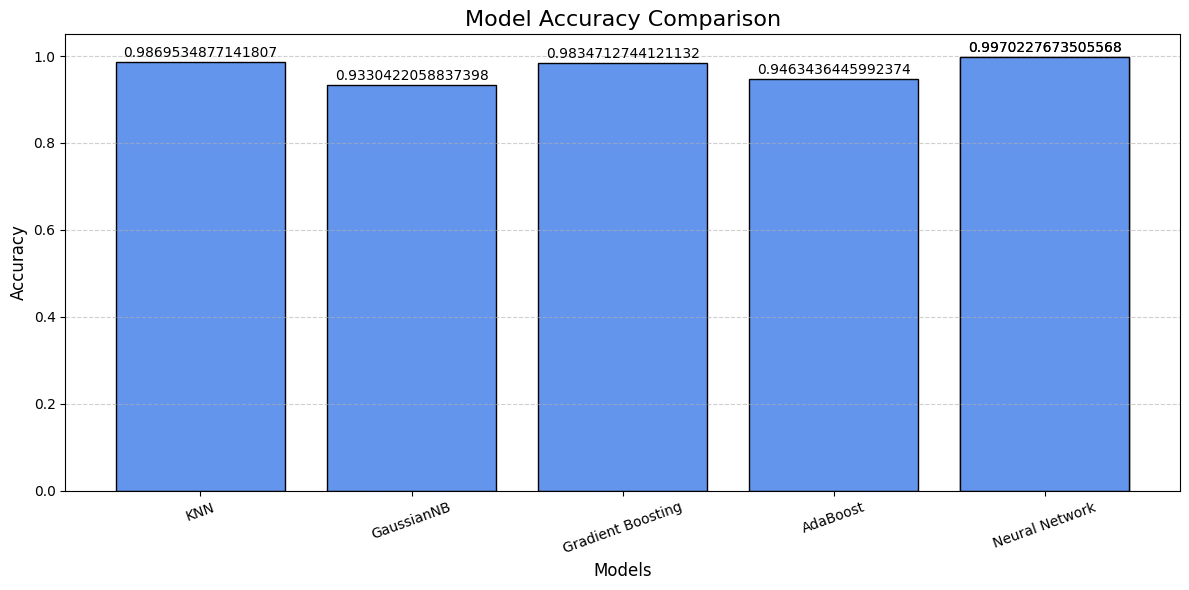

In [ ]:
# Visualizing the Performance of all the models

import matplotlib.pyplot as plt

# Drop unwanted models
filtered_df = result_df[~result_df['Model'].isin(['Decision Tree', 'Random Forest', 'Extra Trees'])].copy()

# Append Neural Network results
nn_metrics = {
    "Model": "Neural Network",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": auc,
    "Log Loss": None,
    "Jaccard": None,
    "MCC": None,
    "Balanced Accuracy": None
}

filtered_df = pd.concat([filtered_df, pd.DataFrame([nn_metrics])], ignore_index=True)

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
bars = plt.bar(filtered_df['Model'], filtered_df['Accuracy'], color='cornflowerblue', edgecolor='black')

# Annotate exact accuracy values
for bar, acc in zip(bars, filtered_df['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, str(acc),
             ha='center', va='bottom', fontsize=10)

plt.title("Model Accuracy Comparison", fontsize=16)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=20)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
